In [ ]:
import tensorflow as tf
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
f1 = ss.norm(loc=3,scale=1)
f0 = ss.norm(loc=1,scale=1)
alpha = .65
f = lambda x: alpha * f1.pdf(x) + (1 - alpha) * f0.pdf(x)

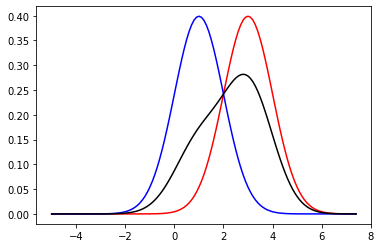

In [ ]:
rng = np.arange(-5,7.5,.1)
plt.plot(rng,f1.pdf(rng),color="red")
plt.plot(rng,f0.pdf(rng),color="blue")
plt.plot(rng,f(rng),color="black")

In [ ]:
x1 = f1.rvs(size=100000)[:,None]
x0 = f0.rvs(size=100000)[:,None]
x = np.concatenate((f1.rvs(size=int(100000*alpha)),
                    f0.rvs(size=int(100000*(1-alpha)))))[:,None]

(array([1.80752293e-04, 5.27035632e-03, 4.24197091e-02, 1.28876385e-01,
        2.08825978e-01, 2.71813395e-01, 2.14438812e-01, 7.05314473e-02,
        8.60951710e-03, 3.61504585e-04]),
 array([-3.22410411, -2.17294179, -1.12177946, -0.07061714,  0.98054518,
         2.03170751,  3.08286983,  4.13403216,  5.18519448,  6.2363568 ,
         7.28751913]),
 <a list of 10 Patch objects>)

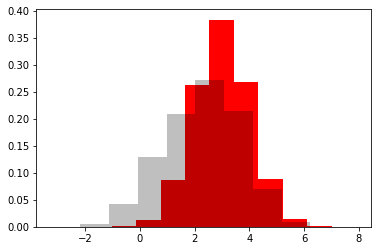

In [ ]:
plt.hist(x1,color="red",density=True)
plt.hist(x,color="black",density=True,alpha=.25)

# Loss

In [ ]:
def _binary_crossentropy(log_ratio_p, log_ratio_q):

            loss_p = tf.nn.sigmoid_cross_entropy_with_logits(
                logits=log_ratio_p,
                labels=tf.ones_like(log_ratio_p)
            )

            loss_q = tf.nn.sigmoid_cross_entropy_with_logits(
                logits=log_ratio_q,
                labels=tf.zeros_like(log_ratio_q)
            )

            return tf.reduce_mean(loss_p + loss_q)

In [ ]:
def _PUBinaryCrossentropy(log_ratio_p,log_ratio_q,alpha):
    loss_p = tf.nn.sigmoid_cross_entropy_with_logits(
                logits=log_ratio_p,
                labels=tf.ones_like(log_ratio_p)
            )

    loss_q = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=log_ratio_q,
        labels=tf.zeros_like(log_ratio_q)
    )
    loss = alpha * tf.reduce_mean(loss_p) + tf.maximum(0.0, tf.reduce_mean(loss_q) - alpha * tf.reduce_mean(loss_p))
    return loss

# Model

In [ ]:
logRatio = tf.keras.models.Sequential([
            tf.keras.layers.Dense(1024,input_dim=x.shape[1],activation="relu"),
            tf.keras.layers.Dense(1024,activation="relu"),
            tf.keras.layers.Dense(1024,activation="relu"),
            tf.keras.layers.Dense(1)
        ])
input1 = tf.keras.layers.Input(shape=(x.shape[1],),name="x1")
input0 = tf.keras.layers.Input(shape=(x.shape[1],),name="x0")
lr1 = logRatio(input1)
lr0 = logRatio(input0)
m = tf.keras.models.Model(inputs=[input1, input0], outputs=[lr1,lr0])
m.add_loss(_PUBinaryCrossentropy(lr1,lr0,alpha))
m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss=None)

In [ ]:
post= lambda x: alpha * f1.pdf(x) / (alpha * f1.pdf(x) + (1-alpha) * f0.pdf(x))

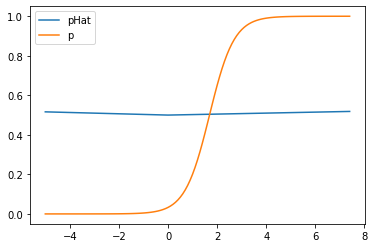

3125/3125 [==============================] - 30s 10ms/step - loss: 0.5901


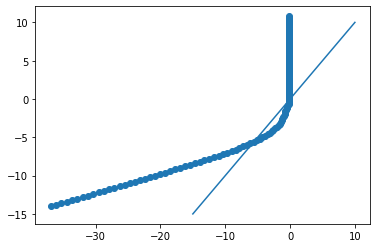

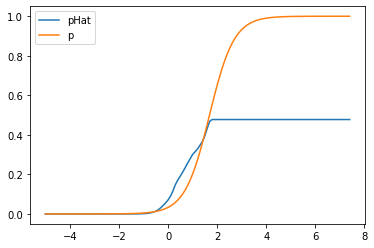

3125/3125 [==============================] - 29s 9ms/step - loss: 0.5351


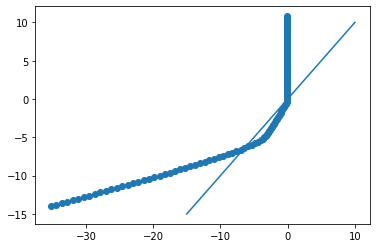

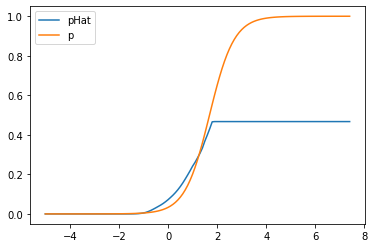

3125/3125 [==============================] - 30s 10ms/step - loss: 0.5348


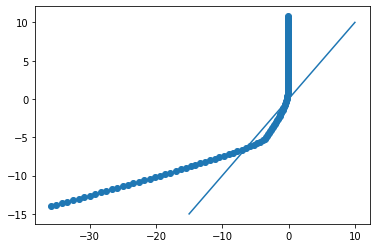

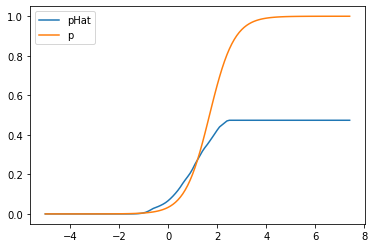

2842/3125 [==========================>...] - ETA: 2s - loss: 0.5338

KeyboardInterrupt: 

In [ ]:
# plt.plot(rng,logRatio.predict(rng[:,None]))
# plt.plot(rng,np.log(f1.pdf(rng)/f0.pdf(rng)))
# plt.show()
plt.plot(rng,tf.math.sigmoid(logRatio.predict(rng)).numpy().ravel(),label="pHat")
plt.plot(rng,post(rng),label="p")
plt.legend()
plt.show()
for sets in range(10):
    m.fit(x={"x1":x1,"x0":x},epochs=1,verbose=1)

#     plt.plot(rng,logRatio.predict(rng[:,None]))
#     plt.plot(rng,np.log(f1.pdf(rng)/f0.pdf(rng)))
#     plt.show()
    plt.scatter(logRatio.predict(rng[:,None]), np.log(f1.pdf(rng) / f0.pdf(rng)))
    plt.plot([-15,10],[-15,10])
    plt.show()
    plt.plot(rng,tf.math.sigmoid(logRatio.predict(rng)).numpy().ravel(),label="pHat")
    plt.plot(rng,post(rng),label="p")
    plt.legend()
    plt.show()